In [55]:
#USPS_results replication
from sklearn import svm
import numpy as np
from tsvm import TSVM
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

with open ('usbs_databases', 'rb') as fp:
    usps_file = pickle.load(fp) 

partition = usps_file[0]
df_usps_sample = usps_file[1]
df_usps_test = usps_file[2]

def k_th_largest_eig(eig,k):
    arr = eig.copy()
    arr.sort() 
    return arr[-k]


def get_mean_and_std(partition,gram='0',method='svm'):
    sigma=6
    accuracy = np.zeros(50)
    gam = 1/(2*sigma**2)
    if(method=='cluster_kernel'): #cluster kernel
        '''trn = df_usps_sample.iloc[:,1:].to_numpy()
        tes = df_usps_test.iloc[:,1:].to_numpy()
        data = np.concatenate((trn,tes),axis=0)
        print('data dimensions', data.shape)'''
        '''lin_ker = extension_cluster_kernel(trn,'linear')
        eig = lin_ker.eigvalues
        print('eig:',eig)
        print('eig length:',eig.shape)
        cut_off = k_th_largest_eig(eig,15)
        print('cut_off:',cut_off)
        lin_ker.poly_step([cut_off,1/2,1])'''
        for i in range(50):
            #for each i, use partition[i] as train, and the rest as test
            data_partition = partition[i].iloc[:,1:]
            targets = partition[i].iloc[:,0].to_numpy()
            inputs =  data_partition.to_numpy()
            #print(inputs)
            unlabeled_df = df_usps_sample.drop(partition[i].index) #'drop' simply ingores the indeces from particion [i], giving us the 'rest'
            unlabeled_targets=unlabeled_df.iloc[:,0].to_numpy()
            unlabeled_inputs =unlabeled_df.iloc[:,1:].to_numpy()
            test_df = df_usps_test
            test_inputs = test_df.iloc[:,1:].to_numpy()
            test_targets= test_df.iloc[:,0].to_numpy()
            
            trn = np.concatenate((inputs,unlabeled_inputs))
            lin_ker = extension_cluster_kernel(trn,'linear')
            eig = lin_ker.eigvalues
            #print('eig:',eig)
            #print('eig length:',eig.shape)
            cut_off = k_th_largest_eig(eig,15)
            #print('cut_off:',cut_off)
            lin_ker.poly_step([cut_off,1/2,1])
            
            
            clf = svm.SVC(kernel=lin_ker.distanceGeneral, C=100,class_weight='balanced')
            print('number of +1:',targets[targets==1].shape)
            print('number of -1:',targets[targets==-1].shape)
            clf.fit(inputs,targets)
            accuracy[i] = clf.score(test_inputs,test_targets)
            print('accuracy at iteration'+str(i)+':',accuracy[i]) 
        print(accuracy)
        print('mean:', np.mean(accuracy))
        print('std:', np.std(accuracy))
    elif(method=='svm'): #svm
        for i in range(50):
            #for each i, use partition[i] as train, and the rest as test
            data_partition = partition[i].iloc[:,1:]
            targets = partition[i].iloc[:,0].to_numpy()
            #data_partition = df_usps_sample.iloc[:,1:]
            #targets = df_usps_sample.iloc[:,0].to_numpy()
            inputs =  data_partition.to_numpy()
            test_df = df_usps_test
            test_targets=test_df.iloc[:,0].to_numpy()
            test_inputs =test_df.iloc[:,1:].to_numpy()
            #print(inputs_scaled.std(axis=0))
            #pca = PCA(n_components = 0.95, svd_solver='full')
            #pca.fit(inputs)
            #transformed_inputs = pca.transform(inputs)
            #transformed_test_inputs = pca.transform(test_inputs)
            clf = svm.SVC(kernel='rbf', C=100,gamma=gam,class_weight='balanced')
            clf.fit(inputs, targets)
            accuracy[i] = clf.score(test_inputs,test_targets)
            print('accuracy at iteration'+str(i)+':',accuracy[i])
        print('sigma:', sigma)
        print(accuracy)
        print('mean:', np.mean(accuracy))
        print('std:', np.std(accuracy))
    elif(method=='tsvm'): #tsvm

        for i in range(50):
            #for each i, use partition[i] as train, and the rest as test
            data_partition = partition[i].iloc[:,1:]
            targets = partition[i].iloc[:,0].to_numpy()
            inputs =  data_partition.to_numpy()
            unlabeled_df = df_usps_sample.drop(partition[i].index) #'drop' simply ingores the indeces from particion [i], giving us the 'rest'
            unlabeled_targets=unlabeled_df.iloc[:,0].to_numpy()
            unlabeled_inputs =unlabeled_df.iloc[:,1:].to_numpy()
            test_df = df_usps_test
            test_inputs = test_df.iloc[:,1:].to_numpy()
            test_targets= test_df.iloc[:,0].to_numpy()
            clf = TSVM()
            gamma = gam 
            C = 10
            clf.initial('rbf',gam,C)
            print(targets)
            clf.train(inputs,targets,unlabeled_inputs)
            test_predict = clf.predict(test_inputs)
            accuracy[i] = test_predict[test_predict==test_targets].size/test_predict.size
            print(accuracy[i])
            #clf = svm.SVC(kernel='rbf', C=10,gamma=gam,class_weight='balanced')
            #clf.fit(inputs, targets)
            #accuracy[i] = clf.score(test_inputs,test_targets)
        print(accuracy)
        print('mean:', np.mean(accuracy))
        print('std:', np.std(accuracy))
    else: #random walk
        
        for i in range(50):
            #for each i, use partition[i] as train, and the rest as test
            data_partition = partition[i].iloc[:,1:]
            targets = partition[i].iloc[:,0].to_numpy()
            inputs =  data_partition.to_numpy()
            unlabeled_df = df_usps_sample.drop(partition[i].index) #'drop' simply ingores the indeces from particion [i], giving us the 'rest'
            unlabeled_targets=unlabeled_df.iloc[:,0].to_numpy()
            unlabeled_inputs =unlabeled_df.iloc[:,1:].to_numpy()
            test_df = df_usps_test
            test_inputs = test_df.iloc[:,1:].to_numpy()
            test_targets= test_df.iloc[:,0].to_numpy()
            
            unl_total = np.concatenate((unlabeled_inputs,test_inputs))
            
            rw = random_walk(inputs,targets,unl_total,gam,2,4)
            res = rw.results
            print(res)
            print(res.shape)
            #test_predict = clf.predict(test_inputs)
            #accuracy[i] = 
            #print(accuracy[i])
            predicted_res = res[40:]
            print(predicted_res.shape)
            targ = np.concatenate((unlabeled_targets,test_targets))
            accuracy[i] = targ[targ==predicted_res].shape[0]/targ.shape[0]
            print(accuracy[i])
            #clf = svm.SVC(kernel='rbf', C=10,gamma=gam,class_weight='balanced')
            #clf.fit(inputs, targets)
            #accuracy[i] = clf.score(test_inputs,test_targets)
        print(accuracy)
        print('mean:', np.mean(accuracy))
        print('std:', np.std(accuracy))

In [57]:
get_mean_and_std(partition,method='cluster_kernel')

number of +1: (20,)
number of -1: (20,)
I am in second branch
(2000, 2007)
Projection [[ 0.04232945 -0.00359036 -0.01180845 ...  0.02176844  0.04164054
  -0.00853262]
 [-0.00179734  0.03360361  0.01685422 ...  0.0200525   0.276622
   0.00801866]
 [ 0.00149801  0.06085257 -0.02610445 ...  0.01352914  0.04956195
  -0.00597817]
 ...
 [ 0.21266026  0.04301656  0.05308995 ...  0.04050648 -0.00188894
  -0.02509798]
 [ 0.1587895  -0.0091046   0.02532049 ...  0.04471847  0.00309389
   0.04034302]
 [ 0.17717756  0.03037018  0.0578368  ...  0.13065738 -0.00101405
  -0.02264693]]
size (40, 2007)
accuracy at iteration0: 0.8659691081215745
number of +1: (20,)
number of -1: (20,)
I am in second branch
(2000, 2007)
Projection [[ 1.83897217e-02  3.99674421e-02 -6.54857650e-03 ...  1.36958036e-02
   2.52377510e-02 -1.80497252e-04]
 [-1.24620310e-02  3.99809185e-02 -2.41312761e-02 ...  2.20639691e-02
   5.10503356e-02 -1.42048074e-02]
 [-3.15196297e-02 -1.00132664e-02 -3.64031557e-02 ... -4.66036968e-03

number of +1: (20,)
number of -1: (20,)
I am in second branch
(2000, 2007)
Projection [[ 2.73604733e-03 -4.72580985e-02 -3.47935322e-02 ...  3.14373706e-03
   7.61326381e-02  3.21118415e-03]
 [ 1.01989163e-02  1.56992072e-02  3.37940056e-02 ... -8.95133212e-03
   4.06493443e-01  2.02992073e-02]
 [-3.62020529e-02 -1.95560811e-02  5.08705043e-03 ... -1.68020352e-02
  -5.92728990e-03  1.45438843e-02]
 ...
 [ 1.75226649e-01 -5.45364025e-03  2.43889533e-02 ...  3.97462545e-02
  -1.11277135e-02  8.41778061e-02]
 [ 1.75915747e-01 -6.44157917e-04  1.65281650e-02 ...  2.02175246e-02
  -3.16873545e-03  3.21379021e-02]
 [ 7.56979458e-03  1.93465929e-02 -2.34220692e-02 ...  6.34119782e-02
   3.65275613e-04  8.74685451e-02]]
size (40, 2007)
accuracy at iteration12: 0.8251121076233184
number of +1: (20,)
number of -1: (20,)
I am in second branch
(2000, 2007)
Projection [[ 4.79842115e-03  6.94767107e-02 -2.15034250e-02 ...  6.35279593e-03
  -7.88630670e-02 -1.31946169e-02]
 [-2.43817980e-02  2.854756

number of +1: (20,)
number of -1: (20,)
I am in second branch
(2000, 2007)
Projection [[ 1.83200059e-02  1.08796421e-02  3.84341732e-02 ...  2.59198223e-02
   3.23992227e-03 -3.57905211e-02]
 [ 4.86637359e-03  1.21504890e-02  1.20047190e-03 ...  3.43548294e-02
   4.65987598e-02 -1.39317344e-02]
 [ 1.29299330e-02 -3.49054418e-03  2.75549882e-02 ... -5.26805161e-04
   5.13594091e-01  2.99207428e-04]
 ...
 [ 4.25199918e-01  1.30310796e-02  7.99755868e-02 ...  5.08987404e-02
   3.30371313e-04 -1.76686419e-02]
 [ 2.54140074e-01 -1.13143741e-02  6.84249581e-02 ...  5.44823979e-02
   3.14059944e-03  4.59407954e-02]
 [ 2.46767427e-01  5.51860478e-03  2.10593467e-02 ...  4.76973904e-02
   5.49652810e-03  1.90337197e-02]]
size (40, 2007)
accuracy at iteration24: 0.809666168410563
number of +1: (20,)
number of -1: (20,)
I am in second branch
(2000, 2007)
Projection [[ 0.01718944  0.03989361  0.00305904 ...  0.02542029  0.02234922
  -0.00530868]
 [-0.02648255 -0.01084361  0.0280488  ... -0.0056366

number of +1: (20,)
number of -1: (20,)
I am in second branch
(2000, 2007)
Projection [[-2.83623639e-02 -3.02189584e-02 -2.68236246e-02 ... -8.18451564e-03
   7.46480201e-03 -1.67760999e-02]
 [ 2.10244556e-02 -1.14744916e-02 -7.69360191e-03 ...  1.95482926e-02
   3.89233017e-02 -1.17807591e-02]
 [ 1.75369379e-02  1.71637805e-02  4.85412856e-02 ... -1.57674733e-04
   5.60123499e-01  2.97873631e-02]
 ...
 [ 2.70183340e-01 -2.03916649e-03  1.88469527e-02 ...  6.92569192e-02
  -1.06420431e-03  1.04317431e-01]
 [ 1.09833093e-01  4.05286387e-03  7.36633285e-02 ...  5.56322400e-02
  -1.42508850e-03 -1.22900234e-03]
 [-5.88495041e-02  1.94238946e-02 -5.02248863e-02 ...  2.50570013e-02
   1.45760318e-04  2.86755086e-01]]
size (40, 2007)
accuracy at iteration37: 0.8131539611360239
number of +1: (20,)
number of -1: (20,)
I am in second branch
(2000, 2007)
Projection [[-0.00096541  0.07138174  0.00144252 ...  0.02132893 -0.04245438
  -0.00790652]
 [ 0.02433158  0.00594655  0.01201632 ...  0.021845

number of +1: (20,)
number of -1: (20,)
I am in second branch
(2000, 2007)
Projection [[ 0.00568317  0.09367342  0.03275735 ...  0.01351342  0.05038198
  -0.00576434]
 [ 0.01415017  0.02640947  0.02087933 ... -0.01456512  0.01492644
   0.00973138]
 [ 0.00472228 -0.03975055 -0.02165389 ... -0.01536769  0.01234126
   0.04584536]
 ...
 [ 0.3191433   0.02895889  0.03169904 ...  0.07042195  0.00464231
   0.02146943]
 [ 0.30581202  0.02743891  0.04674245 ...  0.0622159   0.03539136
   0.00910962]
 [ 0.13600667 -0.00630335  0.00267588 ...  0.06311369  0.00218647
   0.07825099]]
size (40, 2007)
accuracy at iteration49: 0.8320876930742401
[0.86596911 0.85002491 0.8206278  0.85301445 0.8614848  0.836572
 0.84853014 0.84803189 0.84554061 0.81763827 0.85500747 0.85301445
 0.82511211 0.84005979 0.83358246 0.81714001 0.8241156  0.8161435
 0.80866966 0.83806677 0.86248132 0.79720977 0.81116094 0.76631789
 0.80966617 0.85002491 0.82561036 0.83358246 0.84055805 0.8161435
 0.85650224 0.84255107 0.820129

In [56]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
import sys
class extension_cluster_kernel:
    def __init__(self, data, type, parameters=None):
        self.dict = {}
        self.data = data
        for i,d in enumerate(data):
            self.dict[str(d)] = i
        sigma=6
        self.gam = 1/(2*sigma**2)
        K = rbf_kernel(data,gamma=self.gam)
        self.rbfK = K
        self.invRbfK = np.linalg.inv(self.rbfK)
        D = np.zeros((K.shape[0],K.shape[1]))
        diagonalElements = np.sum(K,axis = 1)
        for i in range(D.shape[0]):
            D[i,i] = diagonalElements[i]**(-0.5)
        L = (D.dot(K)).dot(D)
        self.L = L
        self.eigvalues,self.eigvectors = np.linalg.eigh(L)
        if parameters:
            self.K = getattr(self, type)(parameters)
        else:
            self.K = getattr(self, type)()
    def compute_K(self,L):
        D_hat = np.diag((1./(np.diagonal(L) + sys.float_info.epsilon))**(0.5))
        K_hat = (D_hat.dot(L)).dot(D_hat)
        return K_hat
    def linear(self):
        return self.compute_K(self.L)
    def step(self,lambda_cut):
        tmp_eig = np.zeros((len(self.eigvalues),len(self.eigvalues)))
        for i,e in enumerate(self.eigvalues):
            if e >= lambda_cut:
                tmp_eig[i,i] = 1
            else:
                tmp_eig[i,i] = 0
        L_hat = (self.eigvectors.dot(tmp_eig)).dot(self.eigvectors.T)
        self.K = self.compute_K(L_hat)
        return self.K
    def linear_step(self,r):
        tmp_eig = np.diag(self.eigvalues)
        for i,e in enumerate(self.eigvalues):
            if e < r:
                tmp_eig[i,i] = 0
        L_hat = (self.eigvectors.dot(tmp_eig)).dot(self.eigvectors.T)
        self.K = self.compute_K(L_hat)
        return self.K
    def polynomial(self,t):
        tmp_eig = np.diag(np.power(self.eigvalues,t))
        L_hat = (self.eigvectors.dot(tmp_eig)).dot(self.eigvectors.T)
        self.K = self.compute_K(L_hat)
        return self.K
    def poly_step(self,parameter_list):
        cut_off = parameter_list[0]
        p = parameter_list[1]
        q = parameter_list[2]
        tmp_eig = np.zeros((len(self.eigvalues),len(self.eigvalues)))
        for i,e in enumerate(self.eigvalues):
            if e>=cut_off:
                tmp_eig[i,i] = np.power(e,p)
            else:
                tmp_eig[i,i] = np.power(e,q)
        L_hat = (self.eigvectors.dot(tmp_eig)).dot(self.eigvectors.T)
        self.K = self.compute_K(L_hat)
        return self.K
    
    def distance(self,X1,X2):
        gram_matrix = np.zeros((X1.shape[0], X2.shape[0]))
        index2list = np.zeros((X2.shape[0]),dtype=int)
        for j, x2 in enumerate(X2):
            index2list[j] = self.dict[str(x2)]
        for i, x1 in enumerate(X1):
            ind1 = self.dict[str(x1)]
            gram_matrix[i, :] = self.K[ind1,index2list]
        return gram_matrix
    def distanceGeneral(self,X1,X2):
        gram_matrix = np.zeros((X1.shape[0], X2.shape[0]))
        index2list = np.zeros((X2.shape[0]),dtype=int)
        for j, x2 in enumerate(X2):
            if str(x2) in self.dict:
                index2list[j] = self.dict[str(x2)]
            else:
                return self.distance_test(X1,X2)
        for i, x1 in enumerate(X1):
            if str(x1) in self.dict:
                ind1 = self.dict[str(x1)]
                gram_matrix[i, :] = self.K[ind1,index2list]
            else:
                print('I am in second branch')
                return self.distance_test(X2,X1).T
        return gram_matrix
    def distance_test(self,X1,X2):
        index1list = np.zeros((X1.shape[0]),dtype=int)
        for j, x1 in enumerate(X1):
            index1list[j] = self.dict[str(x1)]
        known_samples = self.data[index1list]
        new_samples = X2
        #print('multiplication of kernels', np.dot(self.K,self.invRbfK))
        V = rbf_kernel(new_samples,self.data,gamma=self.gam)
        temp = ((self.K).dot(self.invRbfK)).dot(V.T)
        print(temp.shape)
        projection = np.zeros((X1.shape[0],X2.shape[0]))
        for i in range(X1.shape[0]):
            ind1 = self.dict[str(X1[i])]
            projection[i] = temp[ind1]
        #print('K_hat:',K_hat_cut)
        #print('inverse:',invRbfK_cut)
        print('Projection',projection)
        print('size', projection.shape)
        return projection

In [30]:
data = df_usps_sample.iloc[:,1:].to_numpy()
targets = df_usps_sample.iloc[:,0].to_numpy()
print(data.shape)
print(targets.shape)
my_kernel = extension_cluster_kernel(data,'linear_step',1)

(2000, 256)
(2000,)


KeyboardInterrupt: 

In [59]:
print(my_kernel.K)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [60]:
from sklearn import svm

index = np.random.permutation(data.shape[0])

train_data = data[index[:40]]
Y = targets[index[:40]]

clf = svm.SVC(kernel = my_kernel.distance, C=100)
#clf = svm.SVC(kernel = 'precomputed')

#print(Y)
#print(train_data)

clf.fit(train_data,Y)
#clf.fit(my_kernel.distance(train_data,train_data),Y)


SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel=<bound method extension_cluster_kernel.distance of <__main__.extension_cluster_kernel object at 0x0000026487D84898>>,
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [76]:
test_data = data[index[40:2000]]
y_test = targets[index[40:2000]]
print(test_data.shape)
print(y_test.shape)
#clf.score(test_data,y_test)

(1960, 256)
(1960,)


In [100]:
pred = clf.predict(my_kernel.distance(train_data,test_data))


In [101]:
print(pred[pred==y_test].size/pred.size)

0.475


In [103]:
print(pred[pred==y_test])
print(pred)

[-1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1 -1  1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1]


In [6]:
def k_th_largest_eig(eig,k):
    arr = eig.copy()
    arr.sort() 
    return arr[-k]

ex = [1,2,3,4,5,6,7]
print(k_th_largest_eig(ex,3))

5


In [7]:
lin_ker = extension_cluster_kernel(data,'poly_step',[cut_off,1/2,2])

NameError: name 'data' is not defined

In [86]:
eigenv = lin_ker.eigvalues
print(eigenv)

[5.12272936e-06 5.36717222e-06 5.70439497e-06 ... 6.36924305e-01
 7.44778433e-01 1.00000000e+00]


In [87]:
cut_off = k_th_largest_eig(eigenv,15)
print(cut_off)

0.24595535248034162


In [80]:
lin_ker.linear_step(cut_off)

array([[ 1.        ,  0.16820461,  0.07673395, ...,  0.0084723 ,
         0.00751655,  0.02843456],
       [ 0.16820461,  1.        ,  0.88072997, ...,  0.59363339,
         0.25046989,  0.61090089],
       [ 0.07673395,  0.88072997,  1.        , ...,  0.46465528,
         0.19522036,  0.30295858],
       ...,
       [ 0.0084723 ,  0.59363339,  0.46465528, ...,  1.        ,
         0.71298524,  0.32859715],
       [ 0.00751655,  0.25046989,  0.19522036, ...,  0.71298524,
         1.        , -0.06475393],
       [ 0.02843456,  0.61090089,  0.30295858, ...,  0.32859715,
        -0.06475393,  1.        ]])

In [94]:
clf = svm.SVC(kernel = lin_ker.distance, C = 1000)
clf.fit(train_data,Y)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel=<bound method extension_cluster_kernel.distance of <__main__.extension_cluster_kernel object at 0x0000026488063828>>,
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [95]:
clf.score(test_data,y_test)

0.8112244897959183

In [159]:
lin_ker.poly_step([cut_off,1/2,2])


array([[ 1.        ,  0.00119113,  0.03364855, ..., -0.00997191,
        -0.02174076, -0.01350418],
       [ 0.00119113,  1.        ,  0.1156237 , ...,  0.17011473,
         0.08906751,  0.11379243],
       [ 0.03364855,  0.1156237 ,  1.        , ..., -0.05278648,
         0.03754403, -0.1303005 ],
       ...,
       [-0.00997191,  0.17011473, -0.05278648, ...,  1.        ,
         0.18297684,  0.54376966],
       [-0.02174076,  0.08906751,  0.03754403, ...,  0.18297684,
         1.        ,  0.14113327],
       [-0.01350418,  0.11379243, -0.1303005 , ...,  0.54376966,
         0.14113327,  1.        ]])

In [74]:
class random_walk:
    def __init__(self,labeledData,labels,unlabeledData,gam=None,k=1,t=2):
        data = np.concatenate((labeledData,unlabeledData))
        L = labeledData.shape[0]
        N = data.shape[0]
        labels = (1==labels)*1
        self.W = rbf_kernel(data,gamma=gam)
        for i in range((self.W).shape[0]):
            sort = list(np.argsort(self.W[i]))
            sort.remove(i)
            for j in sort[k:]:
                self.W[i,j]=0
                
        self.W = np.maximum(self.W,(self.W).transpose())
        self.P=np.zeros(((self.W).shape))
        sumRowsW = np.sum(self.W,axis=1)
        for i in range((self.W).shape[0]):
            self.P[i]=self.W[i]/sumRowsW[i]
        
        self.PT = np.linalg.matrix_power(self.P,t)
        
        self.labelProbability = np.zeros((N,2))
        #Initializing random values
        for i in range(N):
            number = (0.5 - np.random.rand())*0.4
            self.labelProbability[i,0] = 0.5+number
            self.labelProbability[i,1]=1-self.labelProbability[i,0]
        
        self.probability = np.zeros((N,L))
        oldloglike = -np.inf
        self.loglike = np.zeros(100)
        for iter in range(100):
            #E Step
            for i in range(N):
                for j in range(L):
                    self.probability[i,j] = self.labelProbability[i,labels[j]]*self.PT[i,j]
                    
            #M Step
            for i in range(N):
                self.labelProbability[i,0] = (np.sum((labels==0)*self.probability[i]))/(np.sum(self.probability[i])+sys.float_info.epsilon)
                self.labelProbability[i,1] = (np.sum((labels==1)*self.probability[i]))/(np.sum(self.probability[i])+sys.float_info.epsilon)
            self.loglike[iter] = np.sum(np.log(np.sum(self.probability,axis=0)))
            if np.abs(self.loglike[iter] - oldloglike) < 10**(-4):
                break
            oldloglike = self.loglike[iter]
        
        self.posterior = np.matmul((self.labelProbability).transpose(),self.PT)
        self.results = ((np.argmax(self.posterior,axis = 0))*2)-1

In [41]:
def JH_bound(dataTrain,targets,dataTest,datatarg):
    data = np.concatenate((dataTrain,dataTest))
    kern = extension_cluster_kernel(data,'linear')
    linearEigval = -np.sort(-kern.eigvalues)[:int((dataTrain.shape[0])/2)]
    #print(linearEigval)
    T = np.zeros((len(linearEigval)))
    er = np.zeros((len(linearEigval)))
    for i,lamda_cut in enumerate(linearEigval):
        kern.poly_step([lamda_cut,1/2,2])
        clf = svm.SVC(C=100,kernel=kern.distance)
        clf.fit(dataTrain,targets)
        #print(clf.dual_coef_)
        alphas = np.abs(clf.dual_coef_).reshape(-1)
        #alphas = clf.dual_coef_.reshape(-1)
        supportV = clf.support_
        for j in range(len(alphas)):
            T[i] += ((alphas[j]*kern.K[supportV[j],supportV[j]]-1)>0)*1
            #print(T[i])
        T[i] = T[i]/dataTrain.shape[0]
        er[i] = 1-clf.score(dataTest,datatarg)
    return T,er

In [110]:
data_partition = partition[0].iloc[:,1:]
targets = partition[0].iloc[:,0].to_numpy()
inputs =  data_partition.to_numpy()
unlabeled_df = df_usps_sample.drop(partition[0].index) #'drop' simply ingores the indeces from particion [i], giving us the 'rest'
unlabeled_targets=unlabeled_df.iloc[:,0].to_numpy()
unlabeled_inputs =unlabeled_df.iloc[:,1:].to_numpy()
test_df = df_usps_test
test_inputs = test_df.iloc[:,1:].to_numpy()
test_targets= test_df.iloc[:,0].to_numpy()

In [43]:
it=50
s = np.zeros((it,20))
true_err = np.zeros((it,20))
for i in range(it):
    data_partition = partition[i].iloc[:,1:]
    targets = partition[i].iloc[:,0].to_numpy()
    inputs =  data_partition.to_numpy()
    unlabeled_df = df_usps_sample.drop(partition[i].index) #'drop' simply ingores the indeces from particion [i], giving us the 'rest'
    unlabeled_targets=unlabeled_df.iloc[:,0].to_numpy()
    unlabeled_inputs =unlabeled_df.iloc[:,1:].to_numpy()
    test_df = df_usps_test
    test_inputs = test_df.iloc[:,1:].to_numpy()
    test_targets= test_df.iloc[:,0].to_numpy()
    tst = np.concatenate((unlabeled_inputs,test_inputs))
    tst_targ = np.concatenate((unlabeled_targets,test_targets))
    s[i],true_err[i] = JH_bound(inputs,targets,tst,tst_targ)

print(s)


[[0.575 0.525 0.55  0.6   0.575 0.6   0.575 0.575 0.55  0.55  0.525 0.525
  0.4   0.375 0.4   0.325 0.375 0.375 0.425 0.4  ]
 [0.7   0.7   0.7   0.7   0.7   0.75  0.725 0.7   0.55  0.65  0.625 0.6
  0.6   0.6   0.625 0.5   0.5   0.45  0.45  0.525]
 [0.675 0.675 0.675 0.7   0.7   0.7   0.7   0.675 0.65  0.625 0.6   0.6
  0.625 0.6   0.55  0.45  0.5   0.45  0.475 0.5  ]
 [0.6   0.55  0.575 0.575 0.6   0.65  0.575 0.575 0.55  0.525 0.45  0.425
  0.45  0.5   0.525 0.45  0.475 0.4   0.475 0.45 ]
 [0.75  0.8   0.8   0.775 0.825 0.775 0.775 0.775 0.725 0.675 0.675 0.7
  0.65  0.65  0.65  0.575 0.575 0.575 0.575 0.55 ]
 [0.625 0.675 0.625 0.625 0.7   0.7   0.7   0.75  0.6   0.525 0.475 0.5
  0.5   0.475 0.5   0.4   0.375 0.375 0.375 0.4  ]
 [0.675 0.675 0.675 0.7   0.7   0.7   0.725 0.75  0.675 0.625 0.675 0.675
  0.625 0.525 0.55  0.45  0.5   0.5   0.475 0.5  ]
 [0.575 0.575 0.575 0.6   0.6   0.65  0.625 0.625 0.6   0.55  0.55  0.55
  0.525 0.5   0.525 0.5   0.475 0.45  0.425 0.475]
 [0.7   0

[0.02862897 0.02849359 0.02815891 0.02931054 0.02933607 0.02811707
 0.02937774 0.03303435 0.03357058 0.02969435 0.03106414 0.03052331
 0.03054304 0.02899824 0.03037554 0.03255957 0.03408579 0.0329077
 0.03271283 0.03148696]


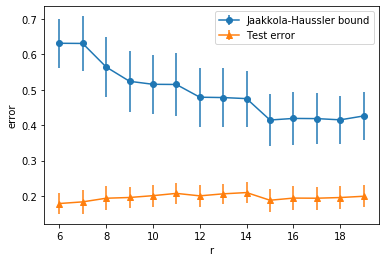

In [54]:
import matplotlib.pyplot as plt

#print(true_err)
s_mean = s.mean(axis=0)
#s_m = s_mean[6:]
s_var = s.std(axis=0)
#s_v = s_var[6:]
err_mean = true_err.mean(axis=0)
#err_m = err_mean[6:]
err_var = true_err.std(axis=0)
print(err_var)
#err_v = err_var[6:]
#print(s_mean)
#print(s_var)
i = range(6,s_mean.shape[0])
plt.errorbar(i,s_mean[6:], yerr=s_var[6:], fmt='-o',label='Jaakkola-Haussler bound')
plt.errorbar(i,err_mean[6:], yerr=err_var[6:], fmt='-^',label='Test error')
plt.xlabel('r')
plt.ylabel('error')
plt.legend()
#plt.plot(s)

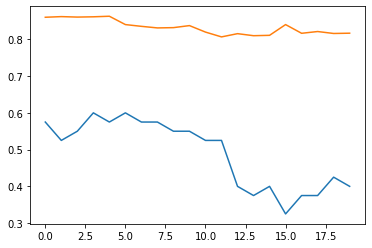

In [40]:
plt.plot(s[0])
plt.plot(true_err[0])